# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [453]:
# just change the width of this document
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
#display(HTML("<style type='text/css'>.CodeMirror{font-size: 15px;</style>"))


In [214]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14.5px;
</style>

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [235]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandasql as pdsql
%matplotlib inline
sns.set()

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration


### 1. portfolio data

In [236]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [237]:
portfolio.rename(columns={"reward":"offer_reward","difficulty":"offer_threshold","duration":"offer_duration_hour"}, inplace=True)
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   offer_reward         10 non-null     int64 
 1   channels             10 non-null     object
 2   offer_threshold      10 non-null     int64 
 3   offer_duration_hour  10 non-null     int64 
 4   offer_type           10 non-null     object
 5   id                   10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### 2. profile data

In [238]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [239]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [240]:
profile.isnull().sum(axis=0)

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

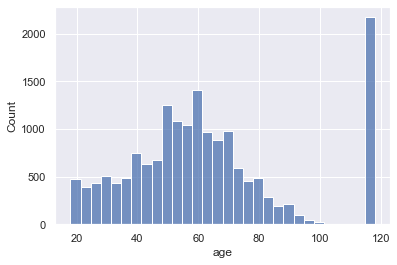

In [241]:
#check distribution of age column
# the distribution of the age looks like a normal distribution except the outlier part
sns.histplot(data=profile, x="age",bins=30);


In [242]:
profile[profile.age==118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


Customers at the edge of 118 have no gender and income value. Age 118 looks like an outlier.

In [243]:
# profile dataset does not have any dupcate row
profile[profile.duplicated(keep=False)]

,gender,age,id,became_member_on,income


### 3. transcript data

In [244]:
transcript[transcript.person =="78afa995795e4d85b5d9ceeca43f5fef"].tail(10)

,person,event,value,time
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378
150598,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408
163375,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408
201572,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504
218393,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 21.72},510
218394,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,510
218395,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,510
230412,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 26.56},534
262138,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582


In [245]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


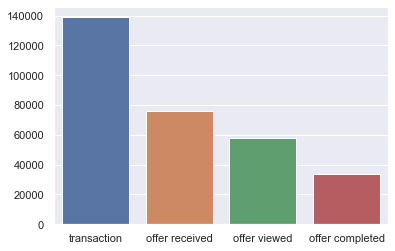

In [246]:
sns.barplot(x=transcript.event.value_counts().index, y=transcript.event.value_counts().values);

In [247]:
transcript.person.value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
afd41b230f924f9ca8f5ed6249616114     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
7ecfc592171f4844bdc05bdbb48d3847     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

# Data Processing

In [248]:
def create_category_labeling(df,cat_col,cat_label_col):
    """
    For a given category column name, this fucntion creates a new column by assigning correspoiding labels(int) to each category
    
    INPUT:
        df: Input DataFrame
        cat_col: Categorical columns to be labeled
        cat_label_col: Corresponding column name to labeled category column values
    
    OUTPUT:
        df: Dataframe with newly added column
    """
    df_new = df.copy() 
    category_types = df_new[cat_col].astype('category').cat.categories.tolist()
    category_type_labelings = {category_type:label for label,category_type in enumerate(category_types,1)}
    df_new[cat_label_col] = df_new[cat_col].map(category_type_labelings)
    
    return df_new


### Portfolio Dataset

In [249]:
# in the portfolio dataframe we need to create new columns
portfolio_new = portfolio.copy()

In [250]:
portfolio_new.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [251]:
portfolio_new.rename(columns={"id":"offer_id"}, inplace=True)

In [252]:
#portfolio_new.channels.str.join(sep=",").str.get_dummies(sep=",")

In [253]:
portfolio_new["channel_web"] = portfolio_new.channels.apply(lambda x: 1 if "web" in x else 0)
portfolio_new["channel_email"] = portfolio_new.channels.apply(lambda x: 1 if "email" in x else 0)
portfolio_new["channel_mobile"] = portfolio_new.channels.apply(lambda x: 1 if "mobile" in x else 0)
portfolio_new["channel_social"] = portfolio_new.channels.apply(lambda x: 1 if "social" in x else 0)
portfolio_new["offer_duration_hour"] = portfolio_new["offer_duration_hour"]*24
portfolio_new.drop(columns=["channels"], inplace=True)
portfolio_new

,offer_reward,offer_threshold,offer_duration_hour,offer_type,offer_id,channel_web,channel_email,channel_mobile,channel_social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [254]:
offer_dict = {
    "ae264e3637204a6fb9bb56bc8210ddfd":"bogo1",
    "4d5c57ea9a6940dd891ad53e9dbe8da0":"bogo2",
    "3f207df678b143eea3cee63160fa8bed":"information1",
    "9b98b8c7a33c4b65b9aebfe6a799e6d9":"bogo3",
    "0b1e1539f2cc45b7b9fa7c272da2e1d7":"discount1",
    "2298d6c36e964ae4a3e7e9706d1fb8c2":"discount2",
    "fafdcd668e3743c1bb461111dcafc2a4":"discount3",
    "5a8bc65990b245e5a138643cd4eb9837":"information2",
    "f19421c1d4aa40978ebb69ca19b0e20d":"bogo3",
    "2906b810c7d4411798c6938adc9daaa5":"discount4"
}
#portfolio_new["offer_id2"] = portfolio_new.offer_id.replace(offer_dict)
col_value = portfolio_new.offer_id.replace(offer_dict)
portfolio_new.insert(6,'offer_id2',col_value)
portfolio_new.head()

,offer_reward,offer_threshold,offer_duration_hour,offer_type,offer_id,channel_web,offer_id2,channel_email,channel_mobile,channel_social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,bogo1,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,bogo2,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,information1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,bogo3,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,discount1,1,0,0


### Profile Dataset

In [255]:
#create the copy of the profile data 
profile_new = profile.copy()
profile_new.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [256]:
profile_new.rename(columns={"id":"customer_id"}, inplace=True)

In [257]:
profile_new["became_member_on"] = pd.to_datetime(profile_new['became_member_on'], format = '%Y%m%d')
profile_new["membership_year"]  = profile_new['became_member_on'].dt.year

In [258]:
profile_new.head()

,gender,age,customer_id,became_member_on,income,membership_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017


In [259]:
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   customer_id       17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   membership_year   17000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 797.0+ KB


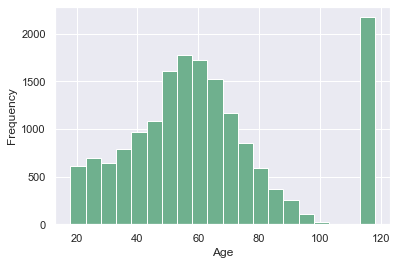

In [260]:
profile_new.age.hist(bins=20,color='#6fb08e')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [261]:
profile[profile.age==118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


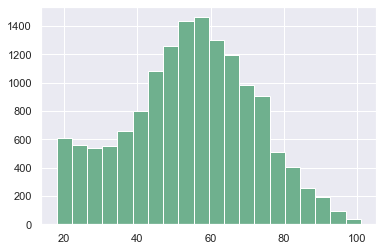

In [262]:
# drop the customers with age of 118
profile_new = profile_new.drop(profile_new[profile_new.age==118].index, axis=0)
profile_new.age.hist(bins=20,color='#6fb08e');

In [263]:
# after droppping the rows with age 118 there is no nan value in the dataset
profile_new.isnull().sum(axis=0)

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
membership_year     0
dtype: int64

In [264]:
profile_new.describe()

,age,income,membership_year
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2016.620169
std,17.383705,21598.299410,1.198245
min,18.000000,30000.000000,2013.000000
25%,42.000000,49000.000000,2016.000000
50%,55.000000,64000.000000,2017.000000
75%,66.000000,80000.000000,2017.000000
max,101.000000,120000.000000,2018.000000


In [265]:
# we can categorize the customers according thp their age
profile_new["age_category"] = pd.cut(profile_new['age'], bins=[17,20,30,40,50,60,70,80,90, 120],\
                                     labels=['18s','20s', '30s','40s', '50s','60s','70s','80s','90s'])

In [266]:
profile_new.isnull().any(axis=0)

gender              False
age                 False
customer_id         False
became_member_on    False
income              False
membership_year     False
age_category        False
dtype: bool

In [267]:
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   membership_year   14825 non-null  int64         
 6   age_category      14825 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 825.6+ KB


<AxesSubplot:>

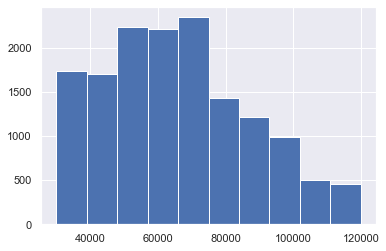

In [268]:
profile_new.income.hist()

In [269]:
profile_new.loc[profile_new.age==118,"income"]

Series([], Name: income, dtype: float64)

In [270]:
profile_new.describe()

,age,income,membership_year
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2016.620169
std,17.383705,21598.299410,1.198245
min,18.000000,30000.000000,2013.000000
25%,42.000000,49000.000000,2016.000000
50%,55.000000,64000.000000,2017.000000
75%,66.000000,80000.000000,2017.000000
max,101.000000,120000.000000,2018.000000


In [271]:
# creating a new column representing the age group to which the customer belongs 
profile_new['income_category'] = pd.cut(profile_new['income'], bins=[20000, 40000, 50000,60000,70000,80000,90000, 130000],\
                                                               labels=['30k+' ,'40k+', '50k+', '60k+', '70k+', '80k+','90k+'])

In [272]:
profile_new.isnull().any(axis=0)

gender              False
age                 False
customer_id         False
became_member_on    False
income              False
membership_year     False
age_category        False
income_category     False
dtype: bool

In [273]:
profile_new.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### Transcript Dataset

In [274]:
transcript_new = transcript.copy()
transcript_new.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [275]:
transcript_new.rename(columns={"person":"customer_id"}, inplace=True)

In [276]:
transcript_new

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [277]:
# convert dictionary string to dictionary
# using ast.literal_eval()
import ast

transcript_new["offer_id"] = transcript_new.value.apply(str).apply(ast.literal_eval).\
                            apply(lambda x:list(x.values())[0] if (list(x.keys())[0]=="offer id")\
                                  or (list(x.keys())[0]=="offer_id") else np.nan)

transcript_new["amount"] = transcript_new.value.apply(str).apply(ast.literal_eval).\
                            apply(lambda x:list(x.values())[0] if (list(x.keys())[0]=="amount") else 0)


In [278]:
# delete event column
transcript_new.drop(columns=["value"],inplace=True)

In [279]:
transcript_new.head()

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [280]:
transcript_new.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Merge DataFrames

In [281]:
transcript_new[transcript_new.isnull().any(axis=1)]

,customer_id,event,time,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53


In [282]:
portfolio_new.isnull().any(axis=0)

offer_reward           False
offer_threshold        False
offer_duration_hour    False
offer_type             False
offer_id               False
channel_web            False
offer_id2              False
channel_email          False
channel_mobile         False
channel_social         False
dtype: bool

In [283]:
transcript_new[transcript_new.event=="transaction"]

,customer_id,event,time,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53


In [284]:
portfolio_new.head()

,offer_reward,offer_threshold,offer_duration_hour,offer_type,offer_id,channel_web,offer_id2,channel_email,channel_mobile,channel_social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,bogo1,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,bogo2,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,information1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,bogo3,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,discount1,1,0,0


In [285]:
df = transcript_new.merge(portfolio_new,how="left", left_on="offer_id",right_on="offer_id")
#df.drop(columns=["id","value", "offer_id"], inplace=True)
df.head()

,customer_id,event,time,offer_id,amount,offer_reward,offer_threshold,offer_duration_hour,offer_type,channel_web,offer_id2,channel_email,channel_mobile,channel_social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,5.0,168.0,bogo,1.0,bogo3,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,20.0,240.0,discount,1.0,discount1,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,10.0,168.0,discount,1.0,discount4,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,10.0,240.0,discount,1.0,discount3,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,10.0,120.0,bogo,1.0,bogo2,1.0,1.0,1.0


In [286]:
df = df.merge(profile_new, how="left", left_on="customer_id",right_on="customer_id")
df.head()

,customer_id,event,time,offer_id,amount,offer_reward,offer_threshold,offer_duration_hour,offer_type,channel_web,...,channel_email,channel_mobile,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,5.0,168.0,bogo,1.0,...,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017.0,70s,90k+
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,20.0,240.0,discount,1.0,...,1.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,10.0,168.0,discount,1.0,...,1.0,1.0,0.0,M,68.0,2018-04-26,70000.0,2018.0,60s,60k+
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,10.0,240.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,10.0,120.0,bogo,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [287]:
#master_df = df.dropna(how='any',axis=0)
#master_df = df.drop(df[df.event=="transaction"].index, axis=0)
master_df = df.copy()
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   customer_id          306534 non-null  object        
 1   event                306534 non-null  object        
 2   time                 306534 non-null  int64         
 3   offer_id             167581 non-null  object        
 4   amount               306534 non-null  float64       
 5   offer_reward         167581 non-null  float64       
 6   offer_threshold      167581 non-null  float64       
 7   offer_duration_hour  167581 non-null  float64       
 8   offer_type           167581 non-null  object        
 9   channel_web          167581 non-null  float64       
 10  offer_id2            167581 non-null  object        
 11  channel_email        167581 non-null  float64       
 12  channel_mobile       167581 non-null  float64       
 13  channel_social

In [288]:
master_df.head()

,customer_id,event,time,offer_id,amount,offer_reward,offer_threshold,offer_duration_hour,offer_type,channel_web,...,channel_email,channel_mobile,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,5.0,168.0,bogo,1.0,...,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017.0,70s,90k+
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,20.0,240.0,discount,1.0,...,1.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,10.0,168.0,discount,1.0,...,1.0,1.0,0.0,M,68.0,2018-04-26,70000.0,2018.0,60s,60k+
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,10.0,240.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,10.0,120.0,bogo,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [289]:
master_df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [290]:
np.mean(profile_new.age)

54.39352445193929

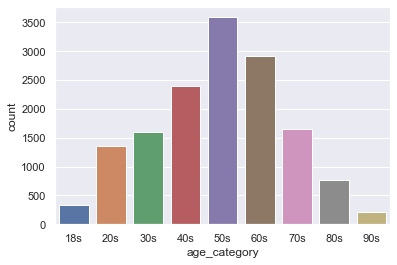

In [291]:
sns.countplot(x="age_category", data=profile_new);

In [292]:
profile_new

,gender,age,customer_id,became_member_on,income,membership_year,age_category,income_category
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,50s,90k+
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,70s,90k+
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,60s,60k+
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,60s,50k+
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,50s,50k+
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,40s,50k+
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,60s,70k+
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,40s,70k+
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,80s,40k+


# Exploratory Data Analysis

### Q1: What is the distribution of customers in each gender category according to their age category?

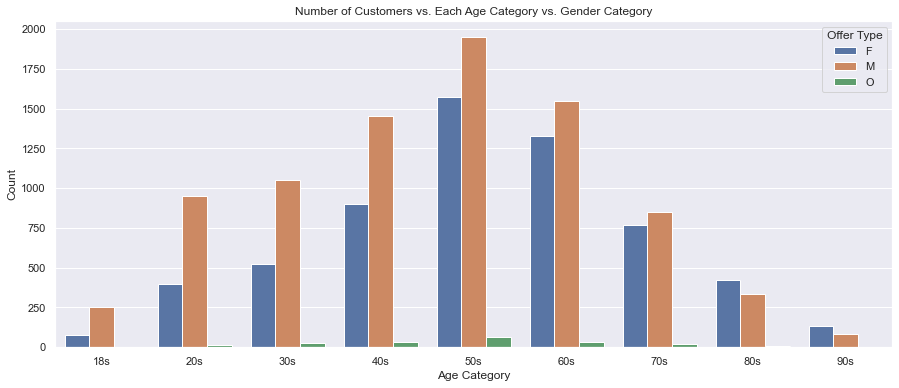

In [293]:
plt.figure(figsize=(15, 6))
sns.set_style('darkgrid')
g = sns.countplot(x="age_category", hue="gender", data=profile_new)
plt.title('Number of Customers vs. Each Age Category vs. Gender Category')
plt.ylabel('Count')
plt.xlabel('Age Category')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [294]:
master_df[master_df.age_category.isnull()==True]

,customer_id,event,time,offer_id,amount,offer_reward,offer_threshold,offer_duration_hour,offer_type,channel_web,...,channel_email,channel_mobile,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,5.0,20.0,240.0,discount,1.0,...,1.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,2.0,10.0,240.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,10.0,10.0,120.0,bogo,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,3.0,7.0,168.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
10,744d603ef08c4f33af5a61c8c7628d1c,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,5.0,20.0,240.0,discount,1.0,...,1.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,3.0,7.0,168.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
306505,b895c57e8cd047a8872ce02aa54759d6,transaction,714,NaN,4.48,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,0.00,2.0,10.0,240.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
306528,5ca2620962114246ab218fc648eb3934,transaction,714,NaN,2.20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


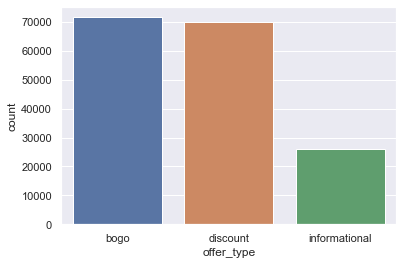

In [295]:
sns.countplot(x="offer_type", data=master_df);

### Q2 - What is the distribution of each offer type in each age category ?

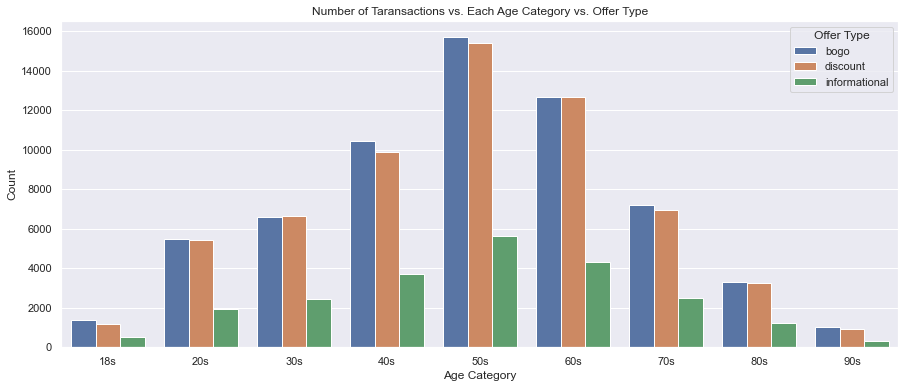

In [296]:
plt.figure(figsize=(15, 6))
sns.set_style('darkgrid')
g = sns.countplot(x="age_category", hue="offer_type", data=master_df)
plt.title('Number of Taransactions vs. Each Age Category vs. Offer Type')
plt.ylabel('Count')
plt.xlabel('Age Category')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [297]:
profile_new.head()

,gender,age,customer_id,became_member_on,income,membership_year,age_category,income_category
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,50s,90k+
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,70s,90k+
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,60s,60k+
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,60s,50k+
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,50s,50k+


### Q3 - Based on the demographic data of the customers who gets the highest income , males or females or other?

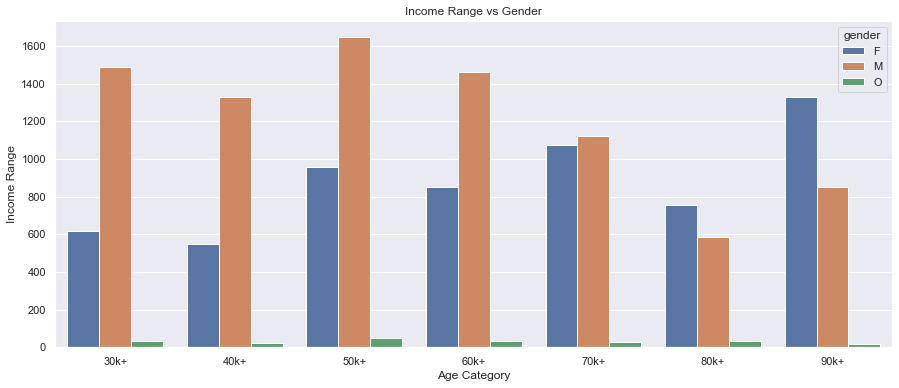

In [387]:
plt.figure(figsize=(15, 6))
g = sns.countplot(x="income_category", hue="gender", data= profile_new)
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
#xlabels = ['Female', 'Male']
#g.set_xticklabels(xlabels)
plt.xlabel('Age Category')
plt.xticks(rotation = 0)
plt.show();

In [299]:
master_df.head()

,customer_id,event,time,offer_id,amount,offer_reward,offer_threshold,offer_duration_hour,offer_type,channel_web,...,channel_email,channel_mobile,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,5.0,168.0,bogo,1.0,...,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017.0,70s,90k+
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,20.0,240.0,discount,1.0,...,1.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,10.0,168.0,discount,1.0,...,1.0,1.0,0.0,M,68.0,2018-04-26,70000.0,2018.0,60s,60k+
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,10.0,240.0,discount,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,10.0,120.0,bogo,1.0,...,1.0,1.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN


### Q4 - How many new members Starbucks got each year?

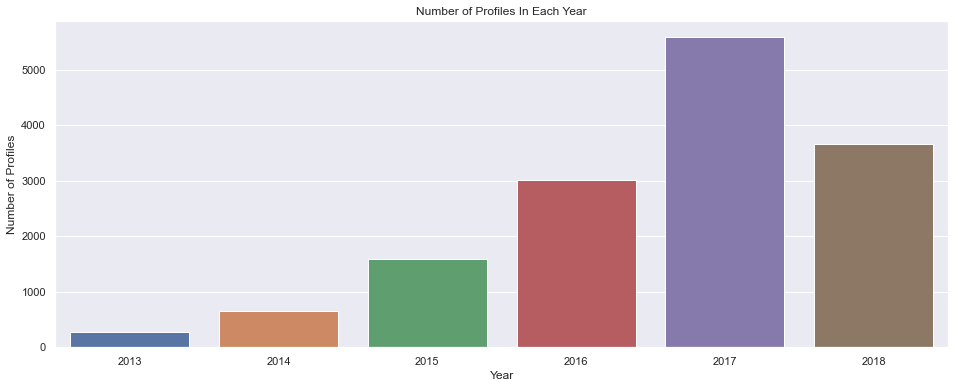

In [300]:
plt.figure(figsize=(16, 6))
sns.countplot(x="membership_year" ,data=profile_new)
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();

### Q5 - What is the distribution of  the offers that each gender receive ?

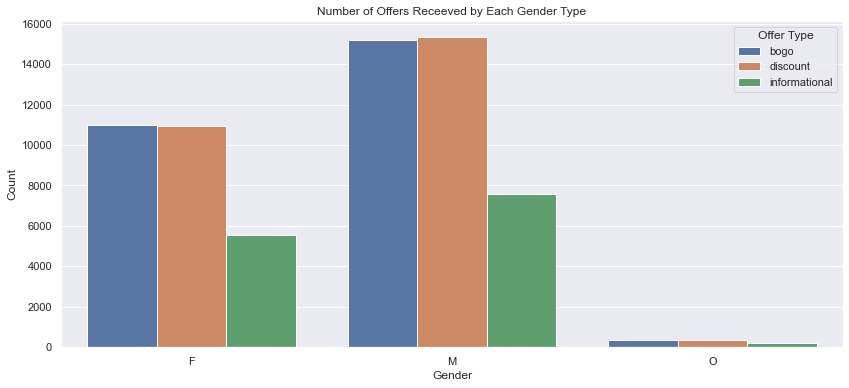

In [301]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= master_df[master_df.event=="offer received"])
plt.title('Number of Offers Receeved by Each Gender Type')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Offer Type')
plt.show();

In [302]:
master_df.head(3)

,customer_id,event,time,offer_id,amount,offer_reward,offer_threshold,offer_duration_hour,offer_type,channel_web,...,channel_email,channel_mobile,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,5.0,168.0,bogo,1.0,...,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017.0,70s,90k+
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,20.0,240.0,discount,1.0,...,1.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,10.0,168.0,discount,1.0,...,1.0,1.0,0.0,M,68.0,2018-04-26,70000.0,2018.0,60s,60k+


In [303]:
master_df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [304]:
master_df[master_df.event=='offer received'].groupby(["gender","offer_type"]).count()["customer_id"]

gender  offer_type   
F       bogo             10975
        discount         10943
        informational     5538
M       bogo             15208
        discount         15354
        informational     7567
O       bogo               354
        discount           367
        informational      195
Name: customer_id, dtype: int64

In [305]:
master_df[master_df.event=='offer received'].groupby(["gender","offer_type"]).count()["customer_id"]

gender  offer_type   
F       bogo             10975
        discount         10943
        informational     5538
M       bogo             15208
        discount         15354
        informational     7567
O       bogo               354
        discount           367
        informational      195
Name: customer_id, dtype: int64

In [306]:
profile_new

,gender,age,customer_id,became_member_on,income,membership_year,age_category,income_category
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,50s,90k+
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,70s,90k+
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,60s,60k+
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,60s,50k+
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,50s,50k+
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,40s,50k+
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,60s,70k+
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,40s,70k+
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,80s,40k+


In [307]:
# Total customers in each gender category 
query = """

            SELECT
                gender,
                count(*) total_customer
                
                FROM
                    profile_new
                GROUP BY
                    gender

        """

pdsql.sqldf(query)

,gender,total_customer
0,F,6129
1,M,8484
2,O,212


In [308]:
# Number of offers received for each gender and offer tyor combination
query = """
            
        SELECT
            master.offer_type,
            master.gender,
            count(master.gender) as reveiced_offers


        FROM
            master_df as master
        WHERE
         event = 'offer received' and gender!=""
        GROUP BY
            offer_type, gender

        """

pdsql.sqldf(query)

,offer_type,gender,reveiced_offers
0,bogo,F,10975
1,bogo,M,15208
2,bogo,O,354
3,discount,F,10943
4,discount,M,15354
5,discount,O,367
6,informational,F,5538
7,informational,M,7567
8,informational,O,195


In [403]:
# Number of offers received on average by a person each gender and offer type combination
query = """
        SELECT
             master.offer_type,
             master.gender,
             master.reveiced_offers,
             portfolio.total_customer,
             ROUND((1.0*master.reveiced_offers)/(1.0*portfolio.total_customer),2) as mean_offer_receive_rate_per_customer
            
        FROM
        (SELECT
            offer_type,
            gender,
            count(*) as reveiced_offers


        FROM
            master_df
        WHERE
         event = 'offer received' and gender!=""
        GROUP BY
            offer_type, gender) master
            
        LEFT JOIN
            (SELECT
                gender,
                count(*) as total_customer
                
                FROM
                    profile_new
                GROUP BY
                    gender
            )  portfolio
        ON
           master.gender= portfolio.gender

        """

pdsql.sqldf(query)

,offer_type,gender,reveiced_offers,total_customer,mean_offer_receive_rate_per_customer
0,bogo,F,10975,6129,1.79
1,bogo,M,15208,8484,1.79
2,bogo,O,354,212,1.67
3,discount,F,10943,6129,1.79
4,discount,M,15354,8484,1.81
5,discount,O,367,212,1.73
6,informational,F,5538,6129,0.90
7,informational,M,7567,8484,0.89
8,informational,O,195,212,0.92


In [443]:
# Number of offers received and completed on average by a person for each gender and offer type combination

# We would like to know the receiving and completion rate in each category 
query = """
        SELECT
             summary.offer_type,
             summary.gender,
             reveiced_offers,
             completed_offers,
             total_customer,
             ROUND((1.0*reveiced_offers)/(1.0*total_customer),2) as mean_offer_receive_rate_per_customer,
             ROUND((1.0*completed_offers)/(1.0*total_customer),2) as mean_offer_completion_rate_per_customer
            
        FROM
            (SELECT
                master1.offer_type,
                master1.gender,
                reveiced_offers,
                completed_offers
                FROM
                    (SELECT
                        offer_type,
                        gender,
                        count(*) as reveiced_offers

                    FROM
                        master_df
                    WHERE
                         event = 'offer received' and gender!=""
                    GROUP BY
                        offer_type, gender) master1


                    JOIN
                    (SELECT
                            offer_type,
                            gender,
                            count(*) as completed_offers

                        FROM
                            master_df
                        WHERE
                         event = 'offer completed'
                        GROUP BY
                            offer_type, gender) master2

                        ON
                           master1.gender= master2.gender and master1.offer_type=master2.offer_type

            ) summary


        
            LEFT JOIN
                (SELECT
                    gender,
                    count(*) as total_customer

                    FROM
                        profile_new
                    GROUP BY
                        gender
                )  portfolio
            ON
               summary.gender= portfolio.gender


        """

pdsql.sqldf(query)

,offer_type,gender,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
0,bogo,F,10975,7501,6129,1.79,1.22
1,bogo,M,15208,7512,8484,1.79,0.89
2,bogo,O,354,245,212,1.67,1.16
3,discount,F,10943,7976,6129,1.79,1.30
4,discount,M,15354,8954,8484,1.81,1.06
5,discount,O,367,256,212,1.73,1.21


According to the data male customers receive more offer in every offer category.When we compare the number of customers in each gender type average number of offers received by a male and female customer is close to each other. However offer completion rate differs significantly. Female and other type customers tend to complete the offer more than male customers.

In [388]:
master_df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'offer_reward',
       'offer_threshold', 'offer_duration_hour', 'offer_type', 'channel_web',
       'offer_id2', 'channel_email', 'channel_mobile', 'channel_social',
       'gender', 'age', 'became_member_on', 'income', 'membership_year',
       'age_category', 'income_category'],
      dtype='object')

In [416]:
# Number of offers received and completed on average by a person for each gender and offer type combination

# We would like to know the receiving and completion rate in each category based on age category
query = """
        SELECT
             summary.offer_type,
             summary.gender,
             summary.age_category,
             reveiced_offers,
             completed_offers,
             total_customer,
             ROUND((1.0*reveiced_offers)/(1.0*total_customer),2) as mean_offer_receive_rate_per_customer,
             ROUND((1.0*completed_offers)/(1.0*total_customer),2) as mean_offer_completion_rate_per_customer
            
        FROM
            (SELECT
                master1.offer_type,
                master1.gender,
                master1.age_category,
                reveiced_offers,
                completed_offers
                FROM
                    (SELECT
                        offer_type,
                        gender,
                        age_category,
                        count(*) as reveiced_offers

                    FROM
                        master_df
                    WHERE
                         event = 'offer received' and gender!=""
                    GROUP BY
                        offer_type, gender, age_category) master1


                    LEFT JOIN
                    (SELECT
                            offer_type,
                            gender,
                            age_category,
                            count(*) as completed_offers

                        FROM
                            master_df
                        WHERE
                         event = 'offer completed'
                        GROUP BY
                            offer_type, gender,age_category) master2

                        ON
                           master1.gender= master2.gender and master1.offer_type=master2.offer_type and master1.age_category=master2.age_category

            ) summary


        
            LEFT JOIN
                (SELECT
                    gender,
                    age_category,
                    count(*) as total_customer

                    FROM
                        profile_new
                    GROUP BY
                        gender,age_category
                )  portfolio
            ON
               summary.gender= portfolio.gender AND summary.age_category=portfolio.age_category


        """

analysis_df  = pdsql.sqldf(query)
analysis_df = analysis_df[analysis_df.offer_type!="informational"]
analysis_df

,offer_type,gender,age_category,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
0,bogo,F,18s,154,87.0,80,1.93,1.09
1,bogo,F,20s,751,463.0,398,1.89,1.16
2,bogo,F,30s,914,602.0,522,1.75,1.15
3,bogo,F,40s,1586,1061.0,898,1.77,1.18
4,bogo,F,50s,2818,2004.0,1574,1.79,1.27
5,bogo,F,60s,2334,1621.0,1327,1.76,1.22
6,bogo,F,70s,1414,946.0,771,1.83,1.23
7,bogo,F,80s,757,550.0,423,1.79,1.30
8,bogo,F,90s,247,167.0,136,1.82,1.23
9,bogo,M,18s,477,153.0,256,1.86,0.60


In [418]:
analysis_df[(analysis_df.offer_type=="bogo") & (analysis_df.gender!="O")]

,offer_type,gender,age_category,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
0,bogo,F,18s,154,87.0,80,1.93,1.09
1,bogo,F,20s,751,463.0,398,1.89,1.16
2,bogo,F,30s,914,602.0,522,1.75,1.15
3,bogo,F,40s,1586,1061.0,898,1.77,1.18
4,bogo,F,50s,2818,2004.0,1574,1.79,1.27
5,bogo,F,60s,2334,1621.0,1327,1.76,1.22
6,bogo,F,70s,1414,946.0,771,1.83,1.23
7,bogo,F,80s,757,550.0,423,1.79,1.30
8,bogo,F,90s,247,167.0,136,1.82,1.23
9,bogo,M,18s,477,153.0,256,1.86,0.60


In [419]:
analysis_df[(analysis_df.offer_type=="discount") & (analysis_df.gender!="O")]

,offer_type,gender,age_category,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
27,discount,F,18s,123,72.0,80,1.54,0.90
28,discount,F,20s,712,473.0,398,1.79,1.19
29,discount,F,30s,956,673.0,522,1.83,1.29
30,discount,F,40s,1589,1129.0,898,1.77,1.26
31,discount,F,50s,2852,2129.0,1574,1.81,1.35
32,discount,F,60s,2376,1790.0,1327,1.79,1.35
33,discount,F,70s,1370,986.0,771,1.78,1.28
34,discount,F,80s,727,551.0,423,1.72,1.30
35,discount,F,90s,238,173.0,136,1.75,1.27
36,discount,M,18s,431,217.0,256,1.68,0.85


In [422]:
# Number of offers received and completed on average by a person for each gender and offer type combination

# We would like to know the receiving and completion rate in each category based on income category
query = """
        SELECT
             summary.offer_type,
             summary.gender,
             summary.income_category,
             reveiced_offers,
             completed_offers,
             total_customer,
             ROUND((1.0*reveiced_offers)/(1.0*total_customer),2) as mean_offer_receive_rate_per_customer,
             ROUND((1.0*completed_offers)/(1.0*total_customer),2) as mean_offer_completion_rate_per_customer
            
        FROM
            (SELECT
                master1.offer_type,
                master1.gender,
                master1.income_category,
                reveiced_offers,
                completed_offers
                FROM
                    (SELECT
                        offer_type,
                        gender,
                        income_category,
                        count(*) as reveiced_offers

                    FROM
                        master_df
                    WHERE
                         event = 'offer received' and gender!=""
                    GROUP BY
                        offer_type, gender, income_category) master1


                    LEFT JOIN
                    (SELECT
                            offer_type,
                            gender,
                            income_category,
                            count(*) as completed_offers

                        FROM
                            master_df
                        WHERE
                         event = 'offer completed'
                        GROUP BY
                            offer_type, gender,income_category) master2

                        ON
                           master1.gender= master2.gender and master1.offer_type=master2.offer_type and master1.income_category=master2.income_category

            ) summary


        
            LEFT JOIN
                (SELECT
                    gender,
                    income_category,
                    count(*) as total_customer

                    FROM
                        profile_new
                    GROUP BY
                        gender,income_category
                )  portfolio
            ON
               summary.gender= portfolio.gender AND summary.income_category=portfolio.income_category


        """

analysis_df2  = pdsql.sqldf(query)
analysis_df2 = analysis_df[analysis_df.offer_type!="informational"]
analysis_df2

,offer_type,gender,income_category,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
0,bogo,F,30k+,1141,571.0,615,1.86,0.93
1,bogo,F,40k+,978,558.0,549,1.78,1.02
2,bogo,F,50k+,1717,1164.0,959,1.79,1.21
3,bogo,F,60k+,1491,1014.0,850,1.75,1.19
4,bogo,F,70k+,1879,1345.0,1073,1.75,1.25
5,bogo,F,80k+,1371,1048.0,755,1.82,1.39
6,bogo,F,90k+,2398,1801.0,1328,1.81,1.36
7,bogo,M,30k+,2714,883.0,1489,1.82,0.59
8,bogo,M,40k+,2336,828.0,1329,1.76,0.62
9,bogo,M,50k+,2958,1373.0,1649,1.79,0.83


In [423]:
analysis_df2[(analysis_df2.offer_type=="bogo") & (analysis_df2.gender!="O")]

,offer_type,gender,income_category,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
0,bogo,F,30k+,1141,571.0,615,1.86,0.93
1,bogo,F,40k+,978,558.0,549,1.78,1.02
2,bogo,F,50k+,1717,1164.0,959,1.79,1.21
3,bogo,F,60k+,1491,1014.0,850,1.75,1.19
4,bogo,F,70k+,1879,1345.0,1073,1.75,1.25
5,bogo,F,80k+,1371,1048.0,755,1.82,1.39
6,bogo,F,90k+,2398,1801.0,1328,1.81,1.36
7,bogo,M,30k+,2714,883.0,1489,1.82,0.59
8,bogo,M,40k+,2336,828.0,1329,1.76,0.62
9,bogo,M,50k+,2958,1373.0,1649,1.79,0.83


In [425]:
analysis_df2[(analysis_df2.offer_type=="discount") & (analysis_df2.gender!="O")]

,offer_type,gender,income_category,reveiced_offers,completed_offers,total_customer,mean_offer_receive_rate_per_customer,mean_offer_completion_rate_per_customer
21,discount,F,30k+,1115,671.0,615,1.81,1.09
22,discount,F,40k+,936,600.0,549,1.70,1.09
23,discount,F,50k+,1753,1251.0,959,1.83,1.30
24,discount,F,60k+,1510,1070.0,850,1.78,1.26
25,discount,F,70k+,1958,1458.0,1073,1.82,1.36
26,discount,F,80k+,1357,1102.0,755,1.80,1.46
27,discount,F,90k+,2314,1824.0,1328,1.74,1.37
28,discount,M,30k+,2705,1186.0,1489,1.82,0.80
29,discount,M,40k+,2417,1162.0,1329,1.82,0.87
30,discount,M,50k+,2965,1635.0,1649,1.80,0.99


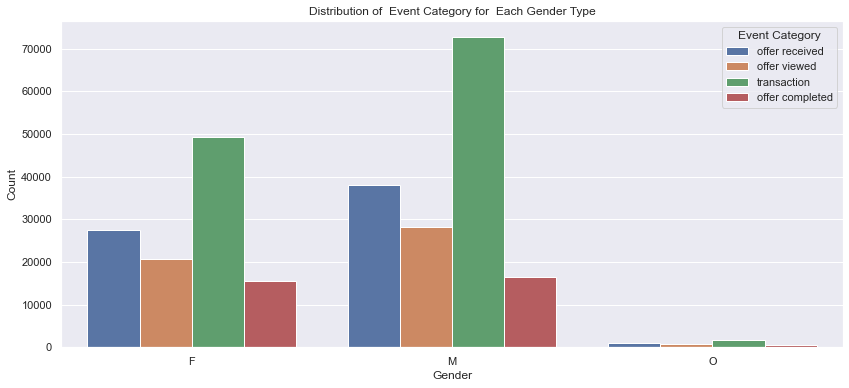

In [311]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= master_df)
plt.title('Distribution of  Event Category for  Each Gender Type')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Event Category')
plt.show();

In [318]:
# We will create a dataframe, each row conxtitutes of distinct customer amd offer type and conatins information about the transcript data summary 
def summary_data(portfolio_new,transcript_new):
    """
    INPUT:
        portfolio_new: DataFrame,Cleaned portfolio dataset
        transcript_new: DataFrame,Cleaned transcript dataset
    OUTPUT:
        df_summary: DataFrame,for each customer and offer_id it provives information about whether the customer viewed the offer or completed the offer,
                    is the customers received an information type of offer during the valid time frame for the offer and time completed for the offer.

    """
    # Reference
    offer_reference = {}

    for i,j in zip(portfolio_new['offer_id'], portfolio_new['offer_type']):
        offer_reference[i] = j


    offer_duration_reference = {}

    for i,j in zip(portfolio_new['offer_id'], portfolio_new['offer_duration_hour']):
        offer_duration_reference[i] = j
    
    customer_id_list = transcript_new.customer_id.unique()

    full_data = []

    # Iterate through each person
    #for person in tqdm(list(transcript['person'].unique())):
    for customer_id in customer_id_list:
        
        # received time of the offer
        not_completed = {}
        received = []
        active = []
        total_data = {}
        information = []

        for index, row in transcript_new[transcript_new['customer_id'] == customer_id].iterrows():

            if row['event'] == 'offer received':

                # Everytime there is an offer received, do this
                received.append(row['offer_id'])
                key = row['offer_id'] + '-' + str(received.count(row['offer_id']))
                not_completed[key] = row['time']
                total_data[key] = [row['customer_id'], row['offer_id'], 0, 0, 0, 0] 


            if row['event'] == 'offer viewed':

                # If the customers have seen the informational offer
                if offer_reference[row['offer_id']] == 'informational':
                    information.append(row['offer_id'])

                # Everytime the offer is viewed, do this
                active = list(filter(lambda x: x.split('-')[0] == row['offer_id'], list(not_completed.keys())))

                # If there is only one offer_id active
                if len(active) == 1:

                    # Only change the value if the offer is not completed yet
                    if active[0] in not_completed:                    
                        total_data[active[0]][2] = 1

                # If there are more than one offer_id active
                else:
                    for offer_id in active:
                        if (row['time'] - not_completed[offer_id]) < offer_duration_reference[row['offer_id']]:
                            if total_data[offer_id][2] == 1:
                                continue
                            total_data[offer_id][2] = 1
                            break


            if row['event'] == 'offer completed':

                # If the users completed the offer and have seen the informational offer
                info = False
                if len(information) > 0:
                    info = True

                # Everytime the offer is completed, do this
                active = list(filter(lambda x: x.split('-')[0] == row['offer_id'], list(not_completed.keys())))

                # If there is only one offer_id active
                if len(active) == 1:
                    total_data[active[0]][3] = 1
                    total_data[active[0]][5] = row['time'] - not_completed[active[0]]
                    not_completed.pop(active[0])

                    if info:
                        total_data[active[0]][4] = 1

                    continue

                # If there is more that one offer_id active
                else:
                    for offer_id in active:
                        if (row['time'] - not_completed[offer_id]) < offer_duration_reference[row['offer_id']]:
                            total_data[offer_id][3] = 1
                            total_data[offer_id][5] = row['time'] - not_completed[offer_id]
                            not_completed.pop(offer_id)

                            if info:
                                total_data[offer_id][4] = 1

                            break

        for index, value in total_data.items():
            full_data += [value]
    
    # Create a dataframe based on the compile result
    compiled_data = pd.DataFrame(full_data, columns=['customer_id', 'offer_id', 'viewed', 'completed', 'view_information', 'time_completed'])
    
    # Merge with the portfolio and profile dataframe
    compiled_data_merged = compiled_data.merge(portfolio_new, left_on='offer_id', right_on='offer_id')
    df_summary = compiled_data_merged.merge(profile_new, left_on='customer_id', right_on='customer_id')
    
    
    return df_summary
            
    

In [319]:
df_summary = summary_data()

In [323]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          66501 non-null  object        
 1   offer_id             66501 non-null  object        
 2   viewed               66501 non-null  int64         
 3   completed            66501 non-null  int64         
 4   view_information     66501 non-null  int64         
 5   time_completed       66501 non-null  int64         
 6   offer_reward         66501 non-null  int64         
 7   offer_threshold      66501 non-null  int64         
 8   offer_duration_hour  66501 non-null  int64         
 9   offer_type           66501 non-null  object        
 10  channel_web          66501 non-null  int64         
 11  offer_id2            66501 non-null  object        
 12  channel_email        66501 non-null  int64         
 13  channel_mobile       66501 non-

In [324]:
df_summary.head(3)

,customer_id,offer_id,viewed,completed,view_information,time_completed,offer_reward,offer_threshold,offer_duration_hour,offer_type,...,channel_email,channel_mobile,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132,5,5,168,bogo,...,1,1,0,F,75,2017-05-09,100000.0,2017,70s,90k+
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,0,0,72,informational,...,1,1,1,F,75,2017-05-09,100000.0,2017,70s,90k+
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102,10,10,168,bogo,...,1,1,1,F,75,2017-05-09,100000.0,2017,70s,90k+


In [325]:
change_columns = df_summary.select_dtypes(include=['category']).columns
df_summary[change_columns] = df_summary[change_columns].astype('object')

In [326]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          66501 non-null  object        
 1   offer_id             66501 non-null  object        
 2   viewed               66501 non-null  int64         
 3   completed            66501 non-null  int64         
 4   view_information     66501 non-null  int64         
 5   time_completed       66501 non-null  int64         
 6   offer_reward         66501 non-null  int64         
 7   offer_threshold      66501 non-null  int64         
 8   offer_duration_hour  66501 non-null  int64         
 9   offer_type           66501 non-null  object        
 10  channel_web          66501 non-null  int64         
 11  offer_id2            66501 non-null  object        
 12  channel_email        66501 non-null  int64         
 13  channel_mobile       66501 non-

In [337]:
query ="""SELECT p.offer_id2,s.*
          FROM df_summary s
          JOIN portfolio_new p
          ON s.offer_id=p.offer_id
            
        """

df_summary = pdsql.sqldf(query)
df_summary

,offer_id2,customer_id,offer_id,viewed,completed,view_information,time_completed,offer_reward,offer_threshold,offer_duration_hour,...,channel_social,gender,age,became_member_on,income,membership_year,age_category,income_category,transaction_amount,transaction
0,bogo3,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132,5,5,168,...,0,F,75,2017-05-09 00:00:00.000000,100000,2017,70s,90k+,0,19.89
1,information2,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,0,0,72,...,1,F,75,2017-05-09 00:00:00.000000,100000,2017,70s,90k+,0,NaN
2,bogo1,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102,10,10,168,...,1,F,75,2017-05-09 00:00:00.000000,100000,2017,70s,90k+,0,21.72
3,bogo3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6,5,5,120,...,1,F,75,2017-05-09 00:00:00.000000,100000,2017,70s,90k+,0,21.72
4,bogo3,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,114,5,5,168,...,0,M,68,2018-04-26 00:00:00.000000,70000,2018,60s,60k+,0,18.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,discount2,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,54,3,7,168,...,1,F,68,2017-06-02 00:00:00.000000,51000,2017,60s,50k+,0,12.05
66497,discount2,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,36,3,7,168,...,1,F,68,2017-06-02 00:00:00.000000,51000,2017,60s,50k+,0,12.05
66498,discount2,9a3f45cf29ef428b932492c7a5d6ac52,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,102,3,7,168,...,1,M,20,2016-10-19 00:00:00.000000,70000,2016,18s,60k+,0,14.25
66499,discount2,ef1e309b68ce4278bf7d80b764bc46d6,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,42,3,7,168,...,1,M,45,2015-09-09 00:00:00.000000,62000,2015,40s,60k+,0,14.81


In [338]:
table = df_summary.groupby("offer_id2").agg({'offer_id':["count"],'viewed':['sum'],'completed':['sum'],'transaction':['sum']})
table.columns = [' '.join(col).strip() for col in table.columns.values]
table

,offer_id count,viewed sum,completed sum,transaction sum
offer_id2,,,,
bogo1,6683,5280,3656,86578.92
bogo2,6593,5853,3302,79873.80
bogo3,13261,8637,8280,157596.56
discount1,6726,1978,3384,87244.62
discount2,6655,5789,4881,88019.99
discount3,6652,5909,5001,95315.00
discount4,6631,2930,3909,80472.08
information1,6657,3446,0,0.00
information2,6643,5799,0,0.00


In [433]:
# calculate the completion ratio for each customer category based on gender, income and age category for different scenarios of completion of the offer.
query = """
        SELECT
            completed.offer_id2,
            total_completed,
            total_completed_with_view,
            total_completed_without_view,
            ROUND(((1.0*total_completed_with_view)/(1.0*total_completed)),2) AS total_completed_with_view_ratio,
            ROUND(((1.0*total_completed_without_view)/(1.0*total_completed)),2) AS total_completed_without_view_ratio,
            total_completed_with_view_reward,
            ROUND(((1.0*total_completed_with_view_reward)/(1.0*total_completed_with_transaction)),2) AS completed_with_view_reward,
            total_completed_without_view_reward
            
            FROM
                (SELECT
                    offer_id,
                    offer_type,
                    offer_id2,
                    count(*) as total_completed
                 FROM
                  df_summary 
                 WHERE
                     completed=1
                 GROUP BY
                     offer_id) completed 
            
            JOIN
                (SELECT
                    offer_id,
                    count(*) as total_completed_with_view,
                    sum(offer_threshold) as total_completed_with_transaction,
                    sum(offer_reward) as total_completed_with_view_reward
                 FROM
                  df_summary 
                 WHERE
                     completed=1 AND viewed=1
                 GROUP BY
                     offer_id) completed_viewed 
            
            ON
                completed.offer_id=completed_viewed.offer_id

            JOIN
                (SELECT
                    offer_id,
                    count(*) as total_completed_without_view,
                    sum(offer_threshold) as total_completed_without_transaction,
                    sum(offer_reward) as total_completed_without_view_reward
                 FROM
                     df_summary 
                 WHERE
                     completed=1 AND viewed=0
                 GROUP BY
                     offer_id) completed_not_viewed 
            
            ON
                completed_viewed.offer_id=completed_not_viewed.offer_id
            
            ORDER BY
                total_completed_without_view_ratio DESC

        """

offer_statistics1  = pdsql.sqldf(query)
offer_statistics1

,offer_id2,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio,total_completed_with_view_reward,completed_with_view_reward,total_completed_without_view_reward
0,discount1,3384,1313,2071,0.39,0.61,6565,0.25,10355
1,bogo3,4185,2031,2154,0.49,0.51,10155,1.00,10770
2,discount4,3909,2043,1866,0.52,0.48,4086,0.20,3732
3,bogo1,3656,2591,1065,0.71,0.29,25910,1.00,10650
4,bogo3,4095,3369,726,0.82,0.18,16845,1.00,3630
5,bogo2,3302,2740,562,0.83,0.17,27400,1.00,5620
6,discount2,4881,4130,751,0.85,0.15,12390,0.43,2253
7,discount3,5001,4362,639,0.87,0.13,8724,0.20,1278


In [454]:
offer_statistics1[["offer_id2","total_completed","total_completed_with_view","total_completed_with_view_ratio","total_completed_with_view_reward"]]

,offer_id2,total_completed,total_completed_with_view,total_completed_with_view_ratio,total_completed_with_view_reward
0,discount1,3384,1313,0.39,6565
1,bogo3,4185,2031,0.49,10155
2,discount4,3909,2043,0.52,4086
3,bogo1,3656,2591,0.71,25910
4,bogo3,4095,3369,0.82,16845
5,bogo2,3302,2740,0.83,27400
6,discount2,4881,4130,0.85,12390
7,discount3,5001,4362,0.87,8724


In [455]:
offer_statistics1[["offer_id2","total_completed","total_completed_without_view","total_completed_without_view_ratio","total_completed_without_view_reward"]]

,offer_id2,total_completed,total_completed_without_view,total_completed_without_view_ratio,total_completed_without_view_reward
0,discount1,3384,2071,0.61,10355
1,bogo3,4185,2154,0.51,10770
2,discount4,3909,1866,0.48,3732
3,bogo1,3656,1065,0.29,10650
4,bogo3,4095,726,0.18,3630
5,bogo2,3302,562,0.17,5620
6,discount2,4881,751,0.15,2253
7,discount3,5001,639,0.13,1278


In [444]:
# calculate the total number of offers in each offer and calculate the view and completion relation with the total number of rewards collected
query = """
        SELECT
            completed.offer_type,
            completed.gender,
            completed.age_category,
            total_completed,
            total_completed_with_view,
            total_completed_without_view,
            ROUND(((1.0*total_completed_with_view)/(1.0*total_completed)),2) AS total_completed_with_view_ratio,
            ROUND(((1.0*total_completed_without_view)/(1.0*total_completed)),2) AS total_completed_without_view_ratio

            
            FROM
                (SELECT
                    offer_type,
                    gender,
                    age_category,
                    count(*) as total_completed
                 FROM
                  df_summary 
                 WHERE
                     completed=1
                 GROUP BY
                     offer_type,gender, age_category) completed 
            
            JOIN
                (SELECT
                    offer_type,
                    gender,
                    age_category,
                    count(*) as total_completed_with_view
                 FROM
                  df_summary 
                 WHERE
                     completed=1 AND viewed=1
                 GROUP BY
                     offer_type,gender,age_category) completed_viewed 
            
            ON
                completed.offer_type=completed_viewed.offer_type AND completed.gender=completed_viewed.gender AND completed.age_category=completed_viewed.age_category

            JOIN
                (SELECT
                    offer_type,
                    gender,
                    age_category,
                    count(*) as total_completed_without_view
                 FROM
                     df_summary 
                 WHERE
                     completed=1 AND viewed=0
                 GROUP BY
                      offer_type,gender,age_category) completed_not_viewed 
            
            ON
                completed_viewed.offer_type=completed_not_viewed.offer_type and completed_viewed.gender=completed_not_viewed.gender and completed_viewed.age_category=completed_not_viewed.age_category
            


        """

offer_statistics2  = pdsql.sqldf(query)
offer_statistics2.head()

,offer_type,gender,age_category,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio
0,bogo,F,18s,87,58,29,0.67,0.33
1,bogo,F,20s,462,293,169,0.63,0.37
2,bogo,F,30s,602,438,164,0.73,0.27
3,bogo,F,40s,1061,808,253,0.76,0.24
4,bogo,F,50s,2002,1366,636,0.68,0.32


In [448]:
offer_statistics2[(offer_statistics2.offer_type=="bogo")]

,offer_type,gender,age_category,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio
0,bogo,F,18s,87,58,29,0.67,0.33
1,bogo,F,20s,462,293,169,0.63,0.37
2,bogo,F,30s,602,438,164,0.73,0.27
3,bogo,F,40s,1061,808,253,0.76,0.24
4,bogo,F,50s,2002,1366,636,0.68,0.32
5,bogo,F,60s,1619,1154,465,0.71,0.29
6,bogo,F,70s,945,647,298,0.68,0.32
7,bogo,F,80s,550,381,169,0.69,0.31
8,bogo,F,90s,167,116,51,0.69,0.31
9,bogo,M,18s,153,100,53,0.65,0.35


In [449]:
offer_statistics2[(offer_statistics2.offer_type=="discount")]

,offer_type,gender,age_category,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio
26,discount,F,18s,72,40,32,0.56,0.44
27,discount,F,20s,473,288,185,0.61,0.39
28,discount,F,30s,672,458,214,0.68,0.32
29,discount,F,40s,1129,816,313,0.72,0.28
30,discount,F,50s,2128,1367,761,0.64,0.36
31,discount,F,60s,1790,1187,603,0.66,0.34
32,discount,F,70s,986,630,356,0.64,0.36
33,discount,F,80s,551,350,201,0.64,0.36
34,discount,F,90s,173,121,52,0.70,0.30
35,discount,M,18s,216,152,64,0.70,0.30


In [450]:
# calculate the total number of offers in each offer and calculate the view and completion relation with the total number of rewards collected
query = """
        SELECT
            completed.offer_type,
            completed.gender,
            completed.income_category,
            total_completed,
            total_completed_with_view,
            total_completed_without_view,
            ROUND(((1.0*total_completed_with_view)/(1.0*total_completed)),2) AS total_completed_with_view_ratio,
            ROUND(((1.0*total_completed_without_view)/(1.0*total_completed)),2) AS total_completed_without_view_ratio

            
            FROM
                (SELECT
                    offer_type,
                    gender,
                    income_category,
                    count(*) as total_completed
                 FROM
                  df_summary 
                 WHERE
                     completed=1
                 GROUP BY
                     offer_type,gender, income_category) completed 
            
            JOIN
                (SELECT
                    offer_type,
                    gender,
                    income_category,
                    count(*) as total_completed_with_view
                 FROM
                  df_summary 
                 WHERE
                     completed=1 AND viewed=1
                 GROUP BY
                     offer_type,gender,income_category) completed_viewed 
            
            ON
                completed.offer_type=completed_viewed.offer_type AND completed.gender=completed_viewed.gender AND completed.income_category=completed_viewed.income_category

            JOIN
                (SELECT
                    offer_type,
                    gender,
                    income_category,
                    count(*) as total_completed_without_view
                 FROM
                     df_summary 
                 WHERE
                     completed=1 AND viewed=0
                 GROUP BY
                      offer_type,gender,income_category) completed_not_viewed 
            
            ON
                completed_viewed.offer_type=completed_not_viewed.offer_type and completed_viewed.gender=completed_not_viewed.gender and completed_viewed.income_category=completed_not_viewed.income_category
            


        """

offer_statistics3  = pdsql.sqldf(query)
offer_statistics3.head()

,offer_type,gender,income_category,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio
0,bogo,F,30k+,571,377,194,0.66,0.34
1,bogo,F,40k+,556,381,175,0.69,0.31
2,bogo,F,50k+,1164,867,297,0.74,0.26
3,bogo,F,60k+,1013,751,262,0.74,0.26
4,bogo,F,70k+,1344,952,392,0.71,0.29


In [451]:
offer_statistics3[(offer_statistics3.offer_type=="bogo")]

,offer_type,gender,income_category,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio
0,bogo,F,30k+,571,377,194,0.66,0.34
1,bogo,F,40k+,556,381,175,0.69,0.31
2,bogo,F,50k+,1164,867,297,0.74,0.26
3,bogo,F,60k+,1013,751,262,0.74,0.26
4,bogo,F,70k+,1344,952,392,0.71,0.29
5,bogo,F,80k+,1047,720,327,0.69,0.31
6,bogo,F,90k+,1800,1213,587,0.67,0.33
7,bogo,M,30k+,879,590,289,0.67,0.33
8,bogo,M,40k+,827,553,274,0.67,0.33
9,bogo,M,50k+,1371,999,372,0.73,0.27


In [452]:
offer_statistics3[(offer_statistics3.offer_type=="discount")]

,offer_type,gender,income_category,total_completed,total_completed_with_view,total_completed_without_view,total_completed_with_view_ratio,total_completed_without_view_ratio
21,discount,F,30k+,671,442,229,0.66,0.34
22,discount,F,40k+,600,369,231,0.62,0.39
23,discount,F,50k+,1251,894,357,0.71,0.29
24,discount,F,60k+,1069,774,295,0.72,0.28
25,discount,F,70k+,1457,974,483,0.67,0.33
26,discount,F,80k+,1102,728,374,0.66,0.34
27,discount,F,90k+,1824,1076,748,0.59,0.41
28,discount,M,30k+,1184,862,322,0.73,0.27
29,discount,M,40k+,1158,807,351,0.70,0.30
30,discount,M,50k+,1635,1269,366,0.78,0.22


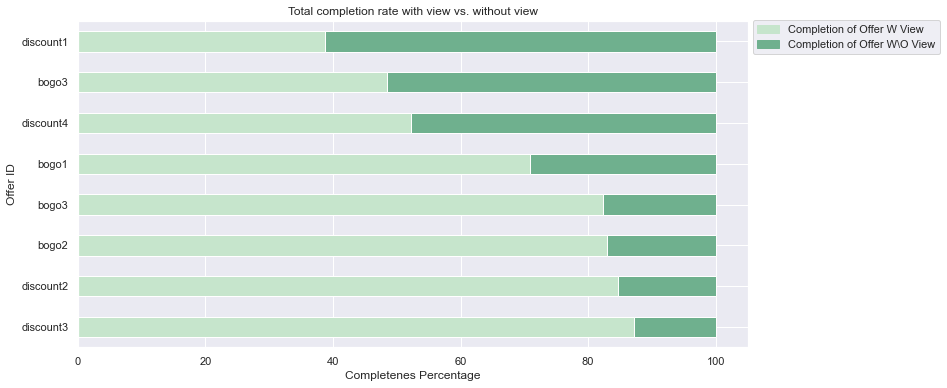

In [973]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

table = offer_statistics[['offer_id2', 'total_completed_with_view_ratio', 'total_completed_without_view_ratio',"offer_type"]]\
                                                                    .set_index('offer_id2') \
                                                                    .sort_values('total_completed_without_view_ratio')


table[['total_completed_with_view_ratio','total_completed_without_view_ratio']].plot(kind='barh',
                              legend=False,
                              stacked=True,
                              color = ['#C6E5CC','#6fb08e'],
                              figsize=(12,6))

with_view = mpatches.Patch(color='#C6E5CC', label='Completion of Offer W View')
without_view = mpatches.Patch(color='#6fb08e', label='Completion of Offer W\O View')


plt.title('Total completion rate with view vs. without view')
plt.xlabel('Completenes Percentage')
plt.ylabel('Offer ID')
plt.legend(loc="upper left",handles=[with_view, without_view],bbox_to_anchor=(1,1.02))
plt.show()

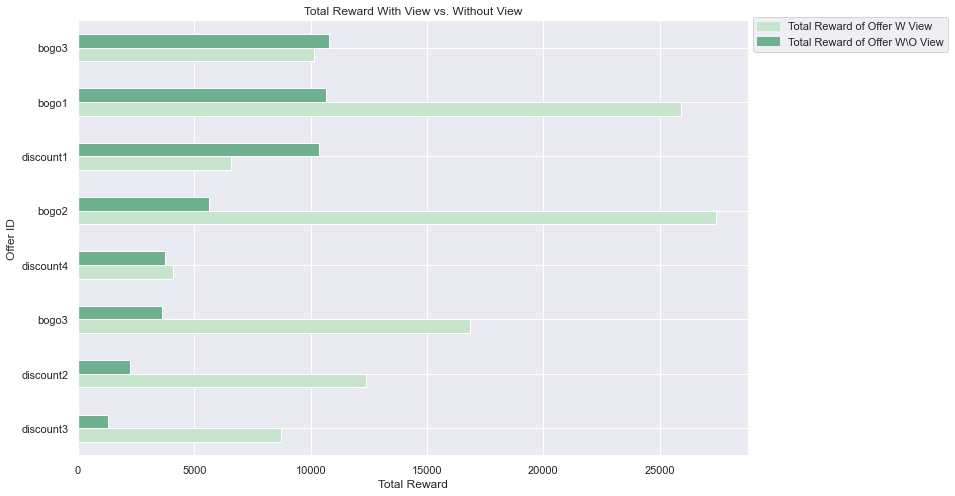

In [974]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

table = offer_statistics1[['offer_id2', 'total_completed_with_view_reward', 'total_completed_without_view_reward']]\
                                                                    .set_index('offer_id2') \
                                                                    .sort_values('total_completed_without_view_reward')


table[['total_completed_with_view_reward','total_completed_without_view_reward']].plot(kind='barh',
                              legend=False,
                              stacked=False,
                              colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.6")),
                              figsize=(12,8))

with_view = mpatches.Patch(color='#C6E5CC', label='Total Reward of Offer W View')
without_view = mpatches.Patch(color='#6fb08e', label='Total Reward of Offer W\O View')


plt.title('Total Reward With View vs. Without View')
plt.xlabel('Total Reward')
plt.ylabel('Offer ID')
plt.legend(loc="upper left",handles=[with_view, without_view],bbox_to_anchor=(1,1.02))
plt.show()

This data covers almost one month period of customer transactions for just one product. As it can be seen in the above graph bogo3 offer has the highest given reward with view.Although bogo1 and bogo2 reward amounts without view is really close to each other, reward with seen amounts difference is really high.We expect that customers react to the offer when they see it compared to the sitiation where they have not seein it. But in bogo3 and discount1 offer, total rewars without seen is bigger than the total reward with seen amounts. In a sense if here is not an underlying connection that we were not able to with that data on hand, customers buy the product no mattter they receive they these two offer. So, total given reward for this offers can be evaluated as a waste investment on promotion. Even thought total reward with seen is bigger than the total reward without seen in discount4 offer, there is still not much difference in the given total amounts. This offer can also be evaluated in the waste investment on promotion.